# Create presentation figures

**Abstract.** This Jupyter Notebook creates figures for a presentation about Kernel Density Esimation. I've attempted to write reasonably clean so that it can be reproduced later on.

## Profiling

In [1]:
import functools
import time
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from KDEpy import FFTKDE
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from KDEpy.utils import cartesian
import tqdm
import openturns as ot

/home/osboxes/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
FIGSIZE = (8, 4)
LEGEND_SIZE = 13
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def timed(n=10, max_time=1.0, use_data_size=True):
    """
    Return a timing function running n times.
    """

    def time_function(function):
        @functools.wraps(function)
        def wrapped(data_size, *args, **kwargs):
            times = []
            for run in range(n):
                if use_data_size:
                    np.random.seed(run)
                    data = np.random.randn(int(data_size))
                else:
                    data = data_size
                start_time = time.perf_counter()
                function(data, *args, **kwargs)
                if time.perf_counter() - start_time > max_time:
                    return None
                times.append(time.perf_counter() - start_time)

            return times
        return wrapped
    return time_function

In [4]:
# -------------------------------------------------------------------------
# --------- Profiling the 1D implementations ------------------------------
# -------------------------------------------------------------------------

@timed()
def KDE_KDEpyFFTKDE(data, kernel='gaussian'):
    return FFTKDE(kernel=kernel).fit(data)()

@timed()
def KDE_scipy(data, kernel='gaussian'):
    kde = gaussian_kde(data)
    x = np.linspace(np.min(data) - 1, np.max(data) + 1, num=2**10)
    return kde(x)

@timed()
def KDE_statsmodels(data, kernel='gaussian'):
    fft = True
    if kernel == 'epa':
        fft = False
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit(fft=fft, gridsize=2**10) 
    return kde.density

@timed()
def KDE_sklearn(data, kernel='gaussian'):
    if kernel == 'epa':
        kernel = 'epanechnikov'

    # instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=1.0, kernel=kernel, rtol=1e-4)
    kde.fit(data.reshape(-1, 1))

    # score_samples returns the log of the probability density
    x = np.linspace(np.min(data) - 1, np.max(data) + 1, num=2**10)
    logprob = kde.score_samples(x.reshape(-1, 1))
    return np.exp(logprob)

@timed()
def KDE_openturns(data, kernel='gaussian'):
    if kernel == 'epa':
        kernel = ot.Epanechnikov()
    else:
        kernel = ot.Gaussian()

    # instantiate and fit the KDE model
    sample = ot.Sample(data, 1)
    factory = ot.KernelSmoothing()
    distribution = factory.build(sample)

    # score_samples returns the log of the probability density
    x = np.linspace(np.min(data) - 1, np.max(data) + 1, num=2**10)
    grid = ot.Sample(x, 1)
    y = distribution.computePDF(grid)
    pdfarray = np.array(y).flatten()
    return pdfarray

100%|██████████| 5/5 [01:02<00:00, 12.42s/it]


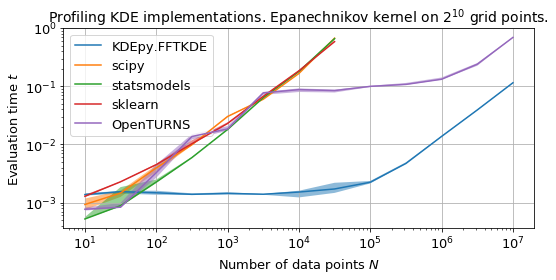

In [5]:
# Do profiling vs. other implementations in one dimentions.
# Set up data, create the figure, perform the computations and create plot.
data_sizes_orig = np.logspace(1, 7, num=13)
plt.figure(figsize=FIGSIZE)
plt.title(
    "Profiling KDE implementations. " + r"Epanechnikov kernel on $2^{10}$ grid points.",
    fontsize=LEGEND_SIZE + 1,
)  # Epanechnikov
algorithms = [KDE_KDEpyFFTKDE, KDE_scipy, KDE_statsmodels, KDE_sklearn, KDE_openturns]
names = ["KDEpy.FFTKDE", "scipy", "statsmodels", "sklearn", "OpenTURNS"]
for function, name in tqdm.tqdm(zip(algorithms, names), total=len(algorithms)):
    agg_times = []
    data_sizes = []
    for data_size in data_sizes_orig:
        # print(name, data_size)
        times = function(data_size, kernel="epa")

        if times is not None:
            agg_times.append(np.percentile(times, q=[25, 50, 75]))
            data_sizes.append(data_size)
        else:
            break

    if name == "KDEpy.FFTKDE":
        lw = 2
    else:
        lw = 1.5
    plt.loglog(data_sizes, [t[1] for t in agg_times], zorder=15, label=name)
    plt.fill_between(
        data_sizes,
        [t[0] for t in agg_times],
        [t[2] for t in agg_times],
        alpha=0.5,
        zorder=-15,
    )

plt.legend(loc="best", fontsize=LEGEND_SIZE)
plt.xticks(fontsize=LEGEND_SIZE)
plt.yticks(fontsize=LEGEND_SIZE)
plt.xlabel("Number of data points $N$", fontsize=LEGEND_SIZE)
plt.ylabel("Evaluation time $t$", fontsize=LEGEND_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig(f'profiling_epa.pdf')
plt.show()